In [1]:
# STEPS
# 1) Load the stock data from Yahoo Finance
# 2) Preprocess the data
# 3) Prepare the training, validation data and test by creating feature and target sets

# LSTM 
# 4) Build the LSTM model architecture
# 5) Train the LSTM model 
# 6) Predict the test set and visualise the predictions (LSTM)
# 7) Evaluate the LSTM model

# Linear Regression
# 8) Train the LR model
# 9) Predict the test set and visualise the predictions (LR)
# 10) Evaluate the LR model

# 11) Comparison between LSTM and LR

In [2]:
!pip install tensorflow
!pip install yfinance
!pip install scikit-learn
!pip install pandas 
!pip install plotly

In [3]:
# Import Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import plotly.express as px
import datetime

# To Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# 1) Load the stock data from Yahoo Finance

# Choose a stock ticker symbol
ticker = "SPY"

# Download historical data from Yahoo Finance
data = yf.download(ticker, start = yf.Ticker(ticker).history(period="max").index.min(), end = datetime.datetime.today().strftime('%Y-%m-%d'))

# Focus on 'Close' prices for simplicity
data = data[['Close']]

# Calculate daily percentage returns
data['Return'] = data['Close'].pct_change()
data = data.dropna() # Removes first row with NaN return

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
# 2) Preprocess the data

# Prepare the data for training (no scalling since we're using percentage returns)
returns = data['Return'].values.reshape(-1, 1)

In [6]:
# 3) Prepare the training, validation data and test by creating feature and target sets

# Define lengths for training, validation and test sets
total_len = len(returns)
train_len = int(np.ceil(total_len * 0.8))
val_len = int(np.ceil(total_len * 0.1))
test_len = total_len - train_len - val_len # Remaining for test set

# Prepare feature and target arrays
def create_features_targets(data):
    x, y = [], []
    for i in range(60, len(data)):
        x.append(data[i-60:i, 0])
        y.append(data[i,0])
    return np.array(x), np.array(y)

# Training data
train_data = returns[:train_len, :]
x_train, y_train = create_features_targets(train_data)

# Validation data
val_data = returns[train_len - 60 : train_len + val_len, :] # starts from train_len - 60 to preserve lookback
x_val, y_val = create_features_targets(val_data)

# Test data
test_data = returns[train_len + val_len - 60 :, :]
x_test, y_test = create_features_targets(test_data)

# Reshape inputs to [samples, time steps, features] for LSTM
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [7]:
# 4) Build the LSTM model architecture
model = Sequential()

# 1st LSTM layer with 100 units and return sequences
model.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting

# 2nd LSTM layer to capture higher order trends
model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.2)) # Dropout layer to prevent overfitting

# Dense layer with 50 units
model.add(Dense(units = 50))

# Output layer with 1 unit (the predicted returns)
model.add(Dense(units = 1))

# Compile the model using "ADAM" optimizer and mean squared error as the loss function
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

Epoch 1/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 1.3163e-04 - val_loss: 1.9124e-04
Epoch 2/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 1.2663e-04 - val_loss: 1.9044e-04
Epoch 3/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.2813e-04 - val_loss: 1.8843e-04
Epoch 4/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.3282e-04 - val_loss: 1.8980e-04
Epoch 5/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.3364e-04 - val_loss: 1.9216e-04
Epoch 6/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 1.3695e-04 - val_loss: 1.8838e-04
Epoch 7/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 1.2910e-04 - val_loss: 1.9091e-04
Epoch 8/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 1.3517e-04 - val_loss: 1.8836e-04
Epoch 9/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 1.3875e-04 - val_loss: 1.8829e-04
Epoch 10/100
203/203 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 1.3455e-04 - val_loss: 1.8846e-04
Epoch 11/100
203/203 ━━━━━━━━━━━━━━━━━

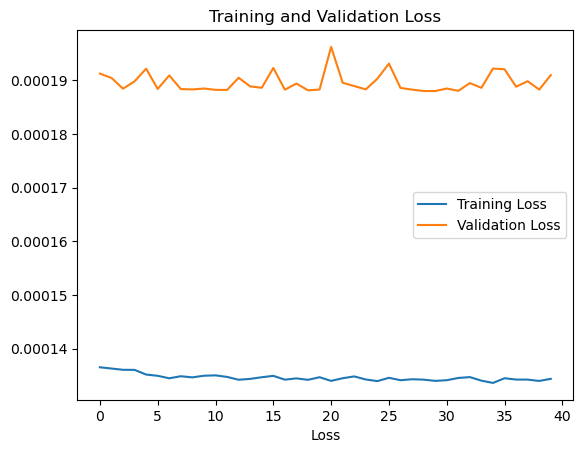

In [8]:
# 5) Train the LSTM model 

# Train the model with validation data
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=100, batch_size=32, callbacks = [early_stop])

# Plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.xlabel("Loss")
plt.legend()
plt.show()

In [9]:
# 6) Predict the test set and visualise the predictions (LSTM)

lstm_predictions = model.predict(x_test) 

# Ensure datetime index
data.index = pd.to_datetime(data.index)

# Test index range
test_start = train_len + val_len
test_dates = data.index[test_start : test_start + len(y_test)]

# Create DataFrame for actual and predicted returns 
plot_df = pd.DataFrame({
    'Actual Return': y_test.ravel(),       
    'Predicted Return': lstm_predictions.ravel()  
}, index = test_dates)


# Create Plotly figure
fig = go.Figure()

# Actual returns
fig.add_trace(go.Scatter(
    x = plot_df.index,
    y = plot_df['Actual Return'],
    mode = 'lines',
    name = 'Actual Return'
))

# Predicted returns
fig.add_trace(go.Scatter(
    x = plot_df.index,
    y = plot_df['Predicted Return'],
    mode = 'lines',
    name = 'Predicted Return'
))

# Layout
fig.update_layout(
    title = 'LSTM Test Set Return Prediction',
    xaxis_title = 'Date',
    yaxis_title = 'Return',
    template = 'plotly_white',
    width = 1000,
    height = 500
)

fig.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Standard Deviation of Returns: 0.0118
LSTM RMSE: 0.0116
LSTM MAE: 0.0080
LSTM Win Rate: 53.73%


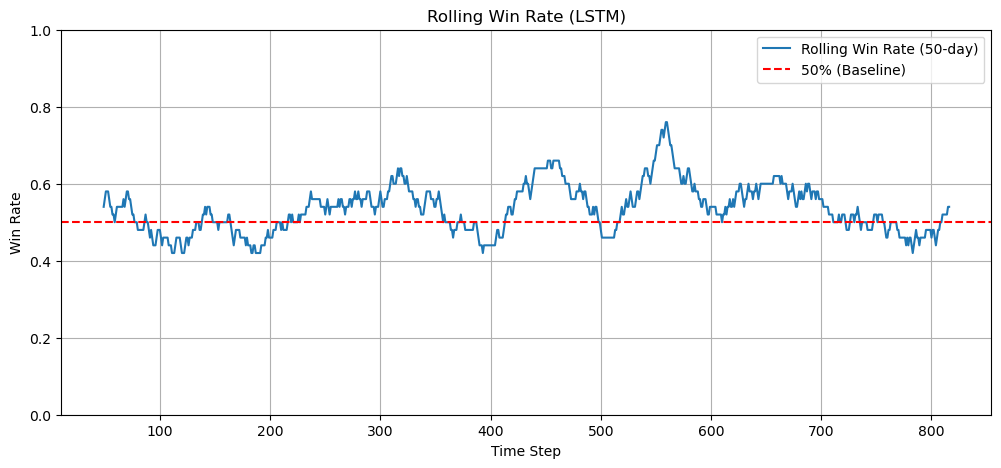

In [12]:
# 7) Evaluate the LSTM model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Flatten arrays
y_true = y_test.flatten()
y_pred = lstm_predictions.flatten()

# Calculate metrics
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_win_rate = np.mean(np.sign(y_pred) == np.sign(y_true))

# Summary
print(f"Standard Deviation of Returns: {np.std(returns):.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM Win Rate: {lstm_win_rate:.2%}")

# Plot win rate 
rolling_lstm_win_rate = pd.Series(np.sign(y_pred) == np.sign(y_true)).rolling(window = 50).mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_lstm_win_rate, label='Rolling Win Rate (50-day)')
plt.axhline(0.5, color='red', linestyle='--', label='50% (Baseline)')
plt.ylim(0, 1)
plt.title('Rolling Win Rate (LSTM)')
plt.ylabel('Win Rate')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# 8) Train the LR model
from sklearn.linear_model import LinearRegression

# Flatten the 3D inputs to 2D: [sample, features]
x_train_lr = x_train.reshape((x_train.shape[0], x_train.shape[1]))
x_val_lr = x_val.reshape((x_val.shape[0], x_val.shape[1]))
x_test_lr = x_test.reshape((x_test.shape[0], x_test.shape[1]))

# Initialise and train model
lr_model = LinearRegression()
lr_model.fit(x_train_lr, y_train)

LinearRegression()

In [15]:
# 9) Predict the test set and visualise the predictions (LR)

lr_predictions = lr_model.predict(x_test_lr)

# Use same test_dates index from earlier
plot_df_lr = pd.DataFrame({
    'Actual Return': y_test.ravel(),
    'LR Predicted Return': lr_predictions
}, index = test_dates)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x = plot_df_lr.index, y = plot_df_lr['Actual Return'], mode = 'lines', name = 'Actual Return'))
fig.add_trace(go.Scatter(x = plot_df_lr.index, y = plot_df_lr['LR Predicted Return'], mode = 'lines', name = 'Linear Regression Prediction'))

fig.update_layout(
    title = 'Linear Regression Test Set Return Prediction',
    xaxis_title = 'Date',
    yaxis_title = 'Return',
    template = 'plotly_white',
    width = 1000,
    height = 500
)
fig.show()

Standard Deviation of Returns: 0.0118
LR RMSE: 0.0119
LR MAE: 0.0083
LR Win Rate: 50.06%


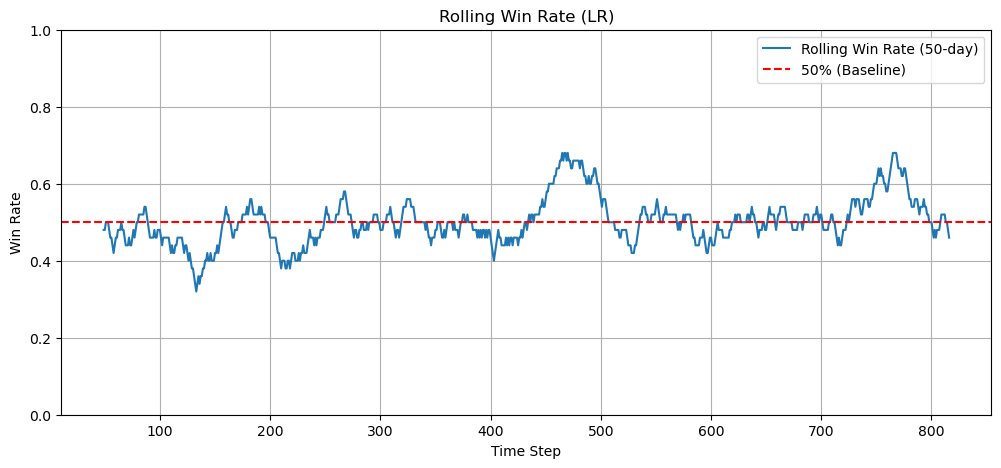

In [18]:
# 10) Evaluate the LR model

# Calculate metrics
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_win_rate = np.mean(np.sign(lr_predictions) == np.sign(y_test.flatten()))

# Summary
print(f"Standard Deviation of Returns: {np.std(returns):.4f}")
print(f"LR RMSE: {lr_rmse:.4f}")
print(f"LR MAE: {lr_mae:.4f}")
print(f"LR Win Rate: {lr_win_rate:.2%}")

# Plot win rate 
rolling_lr_win_rate = pd.Series(np.sign(lr_predictions) == np.sign(y_test.flatten())).rolling(window = 50).mean()
plt.figure(figsize=(12, 5))
plt.plot(rolling_lr_win_rate, label='Rolling Win Rate (50-day)')
plt.axhline(0.5, color='red', linestyle='--', label='50% (Baseline)')
plt.ylim(0, 1)
plt.title('Rolling Win Rate (LR)')
plt.ylabel('Win Rate')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# 11) Comparison between LSTM and LR

# Create comparison table
comparison_df = pd.DataFrame({
    "RMSE": [lstm_rmse, lr_rmse],
    "MAE": [lstm_mae, lr_mae],
    "Win Rate (%)": [lstm_win_rate * 100, lr_win_rate * 100]
}, index=["LSTM", "Linear Regression"])

# Round values for neatness
comparison_df = comparison_df.round(4)

# Display table
print(f"Standard Deviation of Returns: {np.std(returns):.4f}")
print()
print("MODEL COMPARISON TABLE")
print()
print(comparison_df)

Standard Deviation of Returns: 0.0118

MODEL COMPARISON TABLE

                     RMSE     MAE  Win Rate (%)
LSTM               0.0116  0.0080       53.7332
Linear Regression  0.0119  0.0083       50.0612
